## 3 - Deep neural network in TensorFlow 2.0





In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow_probability import distributions as tfd
import tensorflow_probability as tfp

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0


In [2]:
negloglik = lambda y, p_y: -p_y.log_prob(y)


We've seen how to solve simple regression problems in TensorFlow 2.0 and the Keras layers library, but how about doing something deeper?

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
class_names = ['T-shirt/top', 
               'Trouser', 
               'Pullover', 
               'Dress', 
               'Coat',
               'Sandal', 
               'Shirt', 
               'Sneaker', 
               'Bag', 
               'Ankle boot']

Let's explore these data

In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
len(train_labels)

60000

All of the image data we have is represented as a series of pixels, each with an integer r/g/b value of between 0 and 255 -- let's transform those such that they're usable by a neural network.

In [7]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [8]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

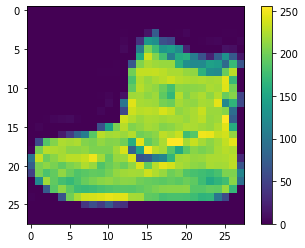

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Standardize the r/g/b pixel values to between zero and one.

In [10]:
train_images = train_images / 255.0

test_images = test_images / 255.0

Let's see what these look like!

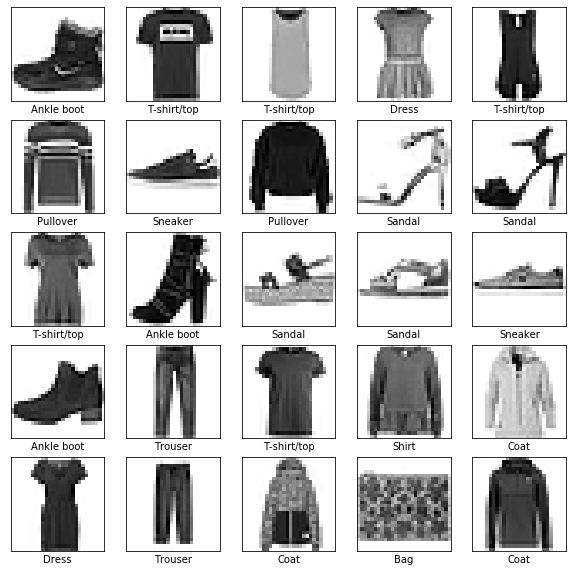

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

Now that we've seen what these images look like and made them consumable by a TensorFlow 2.0 model, let's construct such a model and plug them in.

In [12]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax'),
    tfp.layers.DistributionLambda(
      lambda t: tfd.Categorical(probs=t)),
])

For a loss function, we'll choose sparse softmax cross entropy loss between logit outputs and labels -- this is a great loss function for mutually exclusive discrete classification tasks.

In [13]:
model.compile(optimizer='adam',
              loss=negloglik,  # tf.nn.sparse_softmax_cross_entropy_with_logits
              metrics=['accuracy'])

In [14]:
model.fit(train_images, train_labels.astype('int32'), epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 98us/sample - loss: 2.3038 - accuracy: 0.0539
Epoch 2/10
60000/60000 [==============================] - 6s 93us/sample - loss: 2.3024 - accuracy: 0.0517
Epoch 3/10
60000/60000 [==============================] - 5s 91us/sample - loss: 2.3022 - accuracy: 0.0592
Epoch 4/10
60000/60000 [==============================] - 5s 91us/sample - loss: 2.3021 - accuracy: 0.0613
Epoch 5/10
60000/60000 [==============================] - 5s 91us/sample - loss: 2.3020 - accuracy: 0.0507
Epoch 6/10
60000/60000 [==============================] - 6s 99us/sample - loss: 2.3019 - accuracy: 0.0539
Epoch 7/10
60000/60000 [==============================] - 6s 94us/sample - loss: 2.3018 - accuracy: 0.0613s - los
Epoch 8/10
60000/60000 [==============================] - 6s 93us/sample - loss: 2.3017 - accuracy: 0.0480
Epoch 9/10
60000/60000 [==============================] - 6s 93us/sample - loss: 2.3016 - accuracy: 0.0645
Epoch 1

In [15]:
test_loss, test_acc = model.evaluate(test_images,  test_labels/1.0, verbose=2)

print('\nTest accuracy:', test_acc)

10000/1 - 1s - loss: 2.2962 - accuracy: 0.0319

Test accuracy: 0.031948883


Our model trains fairly quickly, even without a GPU. Fortunately, it's small and fairly shallow as deep neural networks go. Let's take a look at the predictions.

In [16]:
predictions = [model.predict(test_images) for _ in range(10)]

In [17]:
predictions[0][0]

2

Our softmax function effectively squished the model outputs into a distribution and seems to be most heavily activated on class 9. Let's verify that.

In [18]:
np.argmax(predictions[0][0])

0

In [19]:
test_labels[0]

9

In [20]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

IndexError: list index out of range

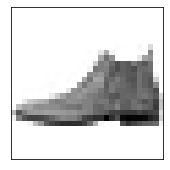

In [21]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Question: are the other outputs of the softmax function probabilities?

Let's now try to plot predictions from the test set generally and see how well we're doing.

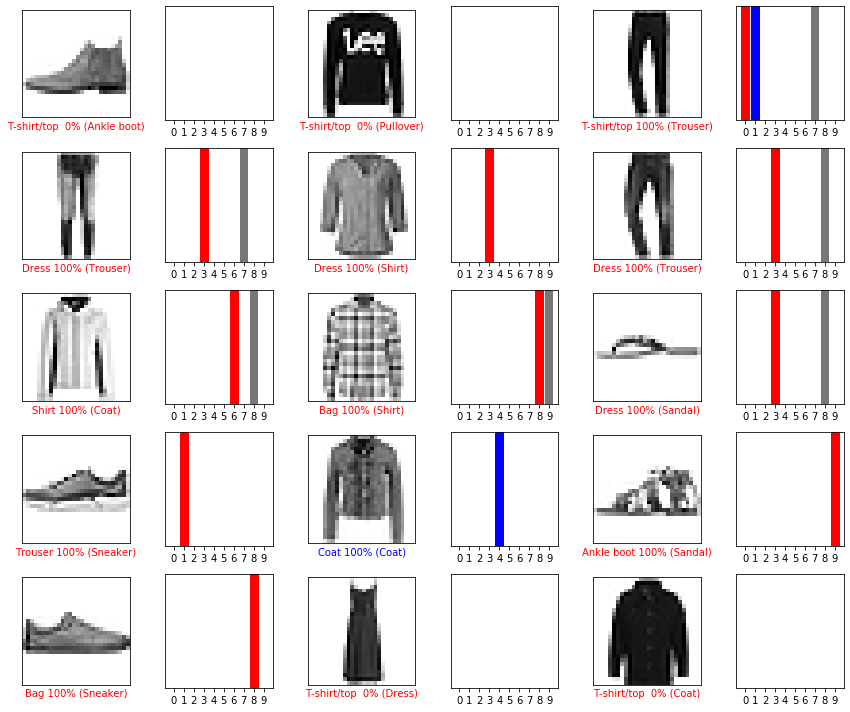

In [29]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Looks good! Just one mistake out of the first fifteen tries.